success,size,topic,acks,compression,inflight,batch,linger,time,rate,latency

In [22]:
import csv

metrics = []
with open('metrics/metrics-corr-1-raw.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        metrics.append(row)

In [23]:
def to_float(s):
    try:
        s=float(s)
    except ValueError:
        pass    
    return s

for metric in metrics:
    for key in metric:
        metric[key] = to_float(metric[key])

In [24]:
def filter_unsuccessful(metric):
    if metric['success'] == 0:
        metric['rate'] = 0
        metric['latency'] = -1
        metric['success'] = 1
    return dict(metric)
        
filtered = [filter_unsuccessful(m) for m in metrics]
filtered

[{'success': 1.0,
  'size': 131072.0,
  'topic': 'test-snappy',
  'acks': -1.0,
  'compression': 'snappy',
  'inflight': 1.0,
  'batch': 0.0,
  'linger': 0.0,
  'time': 4583.0,
  'rate': 66.63,
  'latency': 398.45},
 {'success': 1.0,
  'size': 131072.0,
  'topic': 'test-snappy',
  'acks': -1.0,
  'compression': 'snappy',
  'inflight': 1.0,
  'batch': 0.0,
  'linger': 20.0,
  'time': 4445.0,
  'rate': 69.17,
  'latency': 394.5},
 {'success': 1.0,
  'size': 131072.0,
  'topic': 'test-snappy',
  'acks': -1.0,
  'compression': 'snappy',
  'inflight': 1.0,
  'batch': 0.0,
  'linger': 50.0,
  'time': 4466.0,
  'rate': 69.1,
  'latency': 390.29},
 {'success': 1.0,
  'size': 131072.0,
  'topic': 'test-snappy',
  'acks': -1.0,
  'compression': 'snappy',
  'inflight': 1.0,
  'batch': 0.0,
  'linger': 100.0,
  'time': 4477.0,
  'rate': 69.08,
  'latency': 377.05},
 {'success': 1.0,
  'size': 131072.0,
  'topic': 'test-snappy',
  'acks': -1.0,
  'compression': 'snappy',
  'inflight': 1.0,
  'batch

In [34]:
from itertools import groupby
from operator import itemgetter

grouper = itemgetter('size', 'acks', 'inflight')

sorted_a = sorted(filtered, key=grouper)
grouped = groupby(sorted_a, key=grouper)
sorted_by_rate = {k:sorted(v, key=itemgetter('rate'), reverse=True)[:10] for k, v in grouped}

In [137]:
for conf, metrics in sorted_by_rate.items():
    with open(f"metrics/groups/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(['batch', 'linger', 'rate'])
        for metric in metrics:
            w.writerow([metric['batch'], metric['linger'], metric['rate']])
sorted_by_rate

{(128.0,
  -1.0,
  1.0): [{'success': 1.0,
   'size': 128.0,
   'topic': 'test-snappy',
   'acks': -1.0,
   'compression': 'snappy',
   'inflight': 1.0,
   'batch': 131072.0,
   'linger': 20.0,
   'time': 2245.0,
   'rate': 170.21,
   'latency': 8.91}, {'success': 1.0,
   'size': 128.0,
   'topic': 'test-snappy',
   'acks': -1.0,
   'compression': 'snappy',
   'inflight': 1.0,
   'batch': 131072.0,
   'linger': 1000.0,
   'time': 2262.0,
   'rate': 168.98,
   'latency': 8.38}, {'success': 1.0,
   'size': 128.0,
   'topic': 'test-snappy',
   'acks': -1.0,
   'compression': 'snappy',
   'inflight': 1.0,
   'batch': 2097152.0,
   'linger': 500.0,
   'time': 2278.0,
   'rate': 168.87,
   'latency': 21.03}, {'success': 1.0,
   'size': 128.0,
   'topic': 'test-snappy',
   'acks': -1.0,
   'compression': 'snappy',
   'inflight': 1.0,
   'batch': 32768.0,
   'linger': 200.0,
   'time': 2269.0,
   'rate': 168.64,
   'latency': 3.29}, {'success': 1.0,
   'size': 128.0,
   'topic': 'test-snappy',

In [56]:
from collections import Counter

counters = {}
for g, metrics in sorted_by_rate.items():
    batch_counts = Counter(m['batch'] for m in metrics)
    linger_counts = Counter(m['linger'] for m in metrics)
    counters[g] = {'batch': batch_counts.most_common(1)[0][0], 'linger': linger_counts.most_common(1)[0][0]}

counters

{(128.0, -1.0, 1.0): {'batch': 131072.0, 'linger': 20.0},
 (128.0, -1.0, 5.0): {'batch': 2097152.0, 'linger': 20.0},
 (128.0, 0.0, 1.0): {'batch': 2097152.0, 'linger': 150.0},
 (128.0, 0.0, 5.0): {'batch': 2097152.0, 'linger': 20.0},
 (128.0, 1.0, 1.0): {'batch': 1048576.0, 'linger': 50.0},
 (128.0, 1.0, 5.0): {'batch': 131072.0, 'linger': 700.0},
 (256.0, -1.0, 1.0): {'batch': 2097152.0, 'linger': 100.0},
 (256.0, -1.0, 5.0): {'batch': 2097152.0, 'linger': 50.0},
 (256.0, 0.0, 1.0): {'batch': 2097152.0, 'linger': 700.0},
 (256.0, 0.0, 5.0): {'batch': 1048576.0, 'linger': 500.0},
 (256.0, 1.0, 1.0): {'batch': 1048576.0, 'linger': 50.0},
 (256.0, 1.0, 5.0): {'batch': 1048576.0, 'linger': 500.0},
 (1024.0, -1.0, 1.0): {'batch': 524288.0, 'linger': 200.0},
 (1024.0, -1.0, 5.0): {'batch': 1048576.0, 'linger': 20.0},
 (1024.0, 0.0, 1.0): {'batch': 2097152.0, 'linger': 150.0},
 (1024.0, 0.0, 5.0): {'batch': 4194304.0, 'linger': 150.0},
 (1024.0, 1.0, 1.0): {'batch': 4194304.0, 'linger': 200.

In [103]:
data_batches={}
data_lingers={}
for conf, metric in counters.items():
    if not (conf[1],conf[2]) in data_batches:
        data_batches[(conf[1],conf[2])] = {}
    data_batches[(conf[1],conf[2])][conf[0]] = metric['batch']
    
    if not (conf[1],conf[2]) in data_lingers:
        data_lingers[(conf[1],conf[2])] = {}
    data_lingers[(conf[1],conf[2])][conf[0]] = metric['linger']
    
print(data_lingers)
print(data_batches)

{(-1.0, 1.0): {128.0: 20.0, 256.0: 100.0, 1024.0: 200.0, 8192.0: 150.0, 32768.0: 300.0, 65536.0: 100.0, 131072.0: 1000.0, 524288.0: 50.0, 1048576.0: 100.0, 2097152.0: 1000.0, 4194304.0: 0.0}, (-1.0, 5.0): {128.0: 20.0, 256.0: 50.0, 1024.0: 20.0, 8192.0: 20.0, 32768.0: 300.0, 65536.0: 700.0, 131072.0: 500.0, 524288.0: 200.0, 1048576.0: 200.0, 2097152.0: 150.0, 4194304.0: 50.0}, (0.0, 1.0): {128.0: 150.0, 256.0: 700.0, 1024.0: 150.0, 8192.0: 100.0, 32768.0: 150.0, 65536.0: 1000.0, 131072.0: 300.0, 524288.0: 300.0, 1048576.0: 700.0, 2097152.0: 20.0, 4194304.0: 20.0}, (0.0, 5.0): {128.0: 20.0, 256.0: 500.0, 1024.0: 150.0, 8192.0: 20.0, 32768.0: 50.0, 65536.0: 20.0, 131072.0: 100.0, 524288.0: 500.0, 1048576.0: 300.0, 2097152.0: 200.0, 4194304.0: 200.0}, (1.0, 1.0): {128.0: 50.0, 256.0: 50.0, 1024.0: 200.0, 8192.0: 150.0, 32768.0: 50.0, 65536.0: 20.0, 131072.0: 0.0, 524288.0: 300.0, 1048576.0: 100.0, 2097152.0: 150.0, 4194304.0: 500.0}, (1.0, 5.0): {128.0: 700.0, 256.0: 500.0, 1024.0: 50.0, 

In [134]:
for conf, lingers in data_lingers.items():
    with open(f"metrics/lingers/{conf}", 'w') as f:
        w = csv.writer(f)
        w.writerow(["size"," linger"])
        for size, linger in lingers.items():
            w.writerow([size, linger])
            
for conf, batches in data_batches.items():
    with open(f"metrics/batches/{conf}", 'w') as f:
        w = csv.writer(f, )
        w.writerow(["size", "batch"])
        for size, batch in batches.items():
            w.writerow([size, batch])

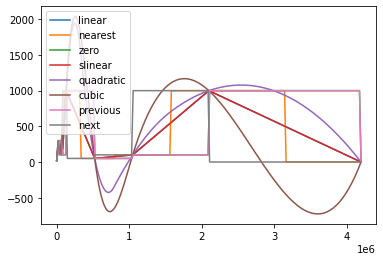

In [127]:
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot

xs = np.linspace(128, 4194304, 200)

for conf, metrics in data_lingers.items():
    f1 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='linear')
    f2 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='nearest')
    f3 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='zero')
    f4 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='slinear')
    f5 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='quadratic')
    f6 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='cubic')
    f7 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='previous')
    f8 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='next')
    pyplot.plot(xs, f1(xs))
    pyplot.plot(xs, f2(xs))
    pyplot.plot(xs, f3(xs))
    pyplot.plot(xs, f4(xs))
    pyplot.plot(xs, f5(xs))
    pyplot.plot(xs, f6(xs))
    pyplot.plot(xs, f7(xs))
    pyplot.plot(xs, f8(xs))
    pyplot.legend(['linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next'], loc='best')
    break
pyplot.show()

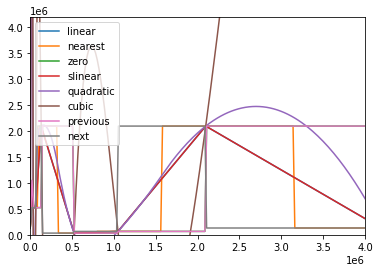

In [112]:
import numpy as np
from matplotlib import pyplot

xs = np.linspace(128, 4194304, 200)

for conf, metrics in data_batches.items():
    f1 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='linear')
    f2 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='nearest')
    f3 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='zero')
    f4 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='slinear')
    f5 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='quadratic')
    f6 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='cubic')
    f7 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='previous')
    f8 = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='next')
    pyplot.plot(xs, f1(xs))
    pyplot.plot(xs, f2(xs))
    pyplot.plot(xs, f3(xs))
    pyplot.plot(xs, f4(xs))
    pyplot.plot(xs, f5(xs))
    pyplot.plot(xs, f6(xs))
    pyplot.plot(xs, f7(xs))
    pyplot.plot(xs, f8(xs))
    pyplot.axis([0, 4000000, 0, 4194304])
    pyplot.legend(['linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next'], loc='best')
    break
pyplot.show()

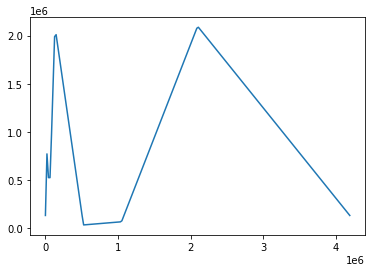

In [126]:
import numpy as np
from matplotlib import pyplot

xs = np.linspace(128, 4194304, 200)

for conf, metrics in data_batches.items():
    f = interp1d(np.array(list(metrics.keys())), np.array(list(metrics.values())), kind='slinear')
    pyplot.plot(xs, f(xs))
    break
#pyplot.axis([-100000, 4000000, -100000, 4194304])
pyplot.show()